# DM-27813 Crowded Fields to Zooniverse

In [110]:
import numpy as np
#%matplotlib notebook
import matplotlib.pyplot as plt
import matplotlib.ticker as plticker
from matplotlib import cm
import pandas as pd
import sqlite3
from astropy.visualization import simple_norm

import lsst.daf.persistence as dafPersist
import lsst.afw.display as afwDisplay
afwDisplay.setDefaultBackend('matplotlib')

import lsst.geom
from lsst.ip.diffim import GetCoaddAsTemplateTask

# local to ap_pipe-notebooks
import plotLightcurve
import apdbPlots

In [2]:
REPO = '/project/sullivan/saha/ap_pipe/cw/'
parent = "/project/sullivan/saha/cwcoadds_processed"

In [3]:
connection = sqlite3.connect(f'{REPO}/association.db')

In [20]:
butler = dafPersist.Butler(inputs=[REPO, parent])

First we want to get a random subset of DIASources from the APDB.

In [57]:
%%time 
# to get a random sample: ORDER BY RANDOM() 
ds_sample = pd.read_sql_query('select * from DiaSource LIMIT 100;', connection)

CPU times: user 28.1 ms, sys: 6.75 ms, total: 34.8 ms
Wall time: 32.9 ms


In [129]:
ds_sample.flags

0     25299404
1     31066572
2     25168328
3     31066600
4     31066568
        ...   
95    25165864
96    41944360
97        1320
98    25167144
99    41944360
Name: flags, Length: 100, dtype: int64

In [58]:
apdbPlots.addVisitCcdToSrcTable(ds_sample)

,diaSourceId,ccdVisitId,diaObjectId,ssObjectId,parentDiaSourceId,prv_procOrder,ssObjectReassocTime,midPointTai,ra,raErr,...,extendedness,spuriousness,flags,pixelId,filterName,filterId,isDipole,bboxSize,ccd,visit
0,184157035032479591,42877401,184157035032479591,0,0,0,None,57116.286309,270.371311,None,...,None,None,25299404,0,g,1,0,33,01,428774
1,184157035032479592,42877401,184157035032479592,0,0,0,None,57116.286309,270.370908,None,...,None,None,31066572,0,g,1,0,36,01,428774
2,184157035032479593,42877401,184157035032479593,0,0,0,None,57116.286309,270.372414,None,...,None,None,25168328,0,g,1,0,48,01,428774
3,184157035032479594,42877401,184157035032479594,0,0,0,None,57116.286309,270.370768,None,...,None,None,31066600,0,g,1,0,26,01,428774
4,184157035032479595,42877401,184157035032479595,0,0,0,None,57116.286309,270.370701,None,...,None,None,31066568,0,g,1,0,17,01,428774
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,184157035032479686,42877401,184157035032479686,0,0,0,None,57116.286309,270.390668,None,...,None,None,25165864,0,g,1,0,15,01,428774
96,184157035032479687,42877401,184157035032479687,0,0,0,None,57116.286309,270.390280,None,...,None,None,41944360,0,g,1,1,21,01,428774
97,184157035032479688,42877401,184157035032479688,0,0,0,None,57116.286309,270.390002,None,...,None,None,1320,0,g,1,0,14,01,428774
98,184157035032479689,42877401,184157035032479689,0,0,0,None,57116.286309,270.390061,None,...,None,None,25167144,0,g,1,0,16,01,428774


## Get calexp, template, and difference cutouts for each source

In [142]:
def get_cutouts(dataId, center, size=lsst.geom.Extent2I(30, 30)):
    """Return a cutout for this dataId at the given source location."""
    # TODO: We can make this a lot faster by loading the images for every "ccd/visit" combo,
    # TODO: and then making the cutouts at each source that lies on that ccd.
    exposure = butler.get('calexp', dataId).getCutout(center, size)
    difference = butler.get('deepDiff_differenceExp', dataId).getCutout(center, size)
    template = butler.get('deepDiff_warpedExp', dataId).getCutout(center, size)
    return exposure, difference, template

In [143]:
# an example dataId and center for playing with making a single image.
i=50
dataId={'ccd': int(ds_sample['ccd'][i]), 'visit': int(ds_sample['visit'][i])}
center=lsst.geom.SpherePoint(ds_sample['ra'][i], ds_sample['decl'][i], lsst.geom.degrees)
exposure, difference, template = get_cutouts(dataId, center)

## Plot the images

In [144]:
def plot_cutout(science, difference, template):
    """Plot the cutouts for a source in one image.
    """
    Qst=15 #Q for Science and Template
    sst=4 #Stretch for Science and Template
    Qd=5 #Q for Difference
    sd=50 #Stretch for Difference
    asinst=0.01
    asind=0.7

    def do_one(ax, data, name):
        norm = simple_norm(data, stretch="asinh", asinh_a=0.05)
        ax.imshow(data, cmap=cm.viridis, interpolation="none", norm=norm)
        ax.axis('off')
        ax.set_title(name)

    f, (ax1, ax2, ax3) = plt.subplots(1, 3)
    do_one(ax1, template.image.array, "Template")
    do_one(ax2, science.image.array, "Science")
    do_one(ax3, difference.image.array, "Difference")
    plt.tight_layout()

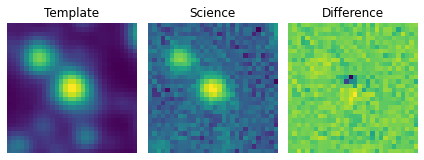

In [145]:
plot_cutout(exposure, difference, template)

## Make plots for every source

In [147]:
# TODO: as currently written, this is going to be *very* slow.

for index,source in ds_sample.iterrows():
    center = lsst.geom.SpherePoint(source['ra'], source['decl'], lsst.geom.degrees)
    dataId = {'ccd': int(source['ccd']), 'visit': int(source['visit'])}
    print(dataId, center)
    exposure, difference, template = get_cutouts(dataId, center)

{'ccd': 1, 'visit': 428774} (270.371311, -29.052358)
{'ccd': 1, 'visit': 428774} (270.370908, -29.056442)
{'ccd': 1, 'visit': 428774} (270.372414, -29.059524)
{'ccd': 1, 'visit': 428774} (270.370768, -29.070485)
{'ccd': 1, 'visit': 428774} (270.370701, -29.077056)
{'ccd': 1, 'visit': 428774} (270.370604, -29.087727)


KeyboardInterrupt: 